In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
#from langchain_google_vertexai import ChatVertexAI
from langchain_openai import ChatOpenAI
import getpass
import os
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
#from pypdf import PdfReader
import chromadb
#from langchain_core.documents import Document
from langchain_chroma import Chroma
from sentence_transformers import SentenceTransformer
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from dotenv import load_dotenv

In [ ]:
load_dotenv(dotenv_path=".env")

def _set_env(key: str):
    if not os.environ.get(key):  # This checks for None or an empty string
        os.environ[key] = getpass.getpass(f"{key}: ")

_set_env("OPENAI_API_KEY")

model = ChatOpenAI(
    model="gpt-4o-mini",
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    collection_name: str
    docs: str

In [20]:
persistent_client = chromadb.PersistentClient(path = "my_local_data")
#collection = persistent_client.get_or_create_collection(name="great_gatsby")

In [21]:

                                                        """AGENTS AND NODES"""
def query_rewrite(state: State):
    
    print("\n---REWRITING QUERY---\n")
    
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""
            
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    
    response = model.invoke(msg)
    print("Rewriten query: " + response.content)
    
    
    return {"messages": [response]}
    

def collection(state: State):
    
    print("\n---FINDING CORRECT COLLECTION---\n")
# Class fo r forcing the output to be specific so that routing can be more consistant
    class collection(BaseModel):

        #Binary choice to use the rag model or not
        collection_name: str = Field(description="The collection to query 'great_gatsby' or")

    llm_with_tool = model.with_structured_output(collection)
    

    prompt = PromptTemplate(
        template=""" your goal is to analize the question given then determine what book the question is asking about
        here is the list of books to chose from:
        "'great_gatsby',
        "
        pick a book from this list and only return the books name as written in the list above thing else
        if the book being referenced in the question is not in the above list say 'END' and nothing else
        """,
        input_variables=["question"],
        )
    
    chain = prompt | llm_with_tool

    messages = state["messages"]
    question = messages[0].content
    
    collection_result = chain.invoke({"question": question})

    collection = collection_result.collection_name

    state_update = {
            "collection_name": collection,
    }

    return Command(update=state_update)

    

def similarity_search(state: State):
    messages = state["messages"]
    question = messages[1].content
    
    print("\n---PREFORMING SIMILARITY SEARCH---\n")

    collection_name = state.get("collection_name")

    print(f"\nsearching collection: {collection_name}\n")
    
    dimensions = 384

    # Defines the embedding model used for future embeddings
    model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=dimensions,)

    # Creates the call for the embedding model and defines our list 
    query_embed = model.encode(question)

    collection = persistent_client.get_or_create_collection(name=collection_name)

    results = collection.query(

    # Defines the embeddings used to be compaired to the collection of embeddings 
    query_embeddings = query_embed,

    # Defines the number of results from the collection
    n_results=5
    )
    
    docs = ""
    
    for x in results["documents"][0]:
        docs += x

    state_update = {
            "docs": docs,
    }

    return Command(update=state_update)

def generate(state: State):

    print("\n---GENERATING INFORMATION---\n")
        
    messages = state["messages"]
    question = messages[0].content
    docs = state.get("docs")

    #print(f"question for gen: {question} docs to pull from: {docs}")

    msg = [
        HumanMessage(
            content=f"""
            
            You are an expert at answering questions using retrieved context chunks from a RAG system.
            Your role is to synthesize information from the chunks to provide accurate, well-supported answers.
            You must explain your reasoning process before providing the answer.
            
            steps=
                1. Analyze the question and available context chunks
                2. Identify the most relevant information in the chunks
                3. Explain how you'll use this information to answer the question
                4. Synthesize information into a coherent answer
        
            output_instructions=
                provide a clear, direct answer based on the context
                If context is insufficient, state this in your reasoning
                Never make up information not present in the chunks
                Focus on being accurate and concise
                do not say anythin else than your answer

            here is the question: {question}

            here are the chunks {docs}
            """,
        )
    ]
    response = model.invoke(msg)

    print("\n---SUMMARY---\n")

    print("summary:", response.content)

    return {"messages": [response]}
        
    


In [ ]:

def route_RAG(state: State):

    # Class fo r forcing the output to be specific so that routing can be more consistant
    class evaluate(BaseModel):

        #Binary choice to use the rag model or not
        eval_score: str = Field(description="Use RAG or not, 'RAG' or 'END'")

    llm_with_tool = model.with_structured_output(evaluate)
    

    prompt = PromptTemplate(
        template="""you are a grader assesing a question to see if useful information could be derived from
        A list of books. if the question asked has any details or information from a book example the book 1984 
        by george orwell you would say 'RAG' DONT SAY ANYTHING ELSE and if the question has nothing to
        do with books you would say 'END' DONT SAY ANYTHING ESLE.
        
        ---steps---
        1. evaluate the users question in detail
        2. determin if the users question has anything to do with a book
        3. if the users output has to do with a book return 'RAG' AND NOTHING ELSE or if the users question
        does not pretain to a book return 'END' AND NOTHING ELSE
        
        ---output instructions---
        1.once a desition is made on a questions relivence for a book return either 'RAG if relivent or 'END' if not relivent
        
        here is the users question: {question}""",
        input_variables=["question"],
        )
    
    chain = prompt | llm_with_tool

    messages = state["messages"]
    question = messages[0].content
    
    route_result = chain.invoke({"question": question})

    route = route_result.eval_score

    if route == 'RAG':
        print("\nROUTE: query_rewrite\n")
        return "query_rewrite"
    elif route == 'END':
        print("\nROUTE: END\n")
        return END
    else:
        print("Error route not valid")
        return END



def route_collection(state: State):
        
    collection = state.get("collection_name")
    if collection == 'END':
        print("\nbook not in collection\n")
        print("\n ROUTE: END\n")
        return END
    else:
        #print("Collection name:", collection)
        print("\n ROUTE: similarity_search\n")
        return "similarity_search"

    

In [23]:
# Building the state and graph

graph_builder = StateGraph(State)

graph_builder.add_node("query_rewrite", query_rewrite)

graph_builder.add_node("similarity_search", similarity_search)

graph_builder.add_node("collection", collection)

graph_builder.add_node("generate", generate)

# conditional edge for chatbots desition to use the rag model or not

graph_builder.add_conditional_edges(START, route_RAG,{"query_rewrite": "query_rewrite", "__end__": "__end__"})

#route_RAG can go to END and query_rewite

graph_builder.add_edge("query_rewrite", "collection")

graph_builder.add_conditional_edges("collection", route_collection, {"similarity_search": "similarity_search", "__end__": "__end__"})

graph_builder.add_edge("similarity_search", "generate")

graph_builder.add_edge("generate", END)
#graph_builder.add_edge("query_rewrite", END)

In [24]:
graph = graph_builder.compile()

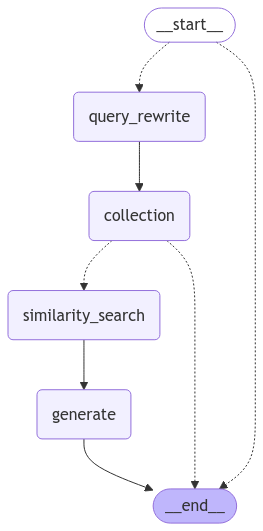

In [25]:
# Image for structure of the graph of nodes and edges
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        stream_mode = "debug"
        #for value in event.values():
            #print("Assistant:", value["messages"][-1].content)
            #message += value["messages"][-1].content

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

    """except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break"""
"""
#user_input = input("User: ")
user_input = "where does gatsby describe his cars and their colors"
#user_input = "test"
#user_input = "why is george orwells 1984 seen as weird"

stream_graph_updates(user_input)
"""
# where does gatsby describe his cars and their colors

User:  test



ROUTE: END



User:  where does gatsby describe his cars and their colors



ROUTE: query_rewrite


---REWRITING QUERY---

Rewriten query: In which chapter or passage of "The Great Gatsby" does the character Jay Gatsby describe his cars and their colors?

---FINDING CORRECT COLLECTION---


 ROUTE: similarity_search


---PREFORMING SIMILARITY SEARCH---


searching collection: great_gatsby


---GENERATING INFORMATION---


---SUMMARY---

summary: Gatsby describes the colors of his cars, specifically mentioning a "yellow car" when he is inquiring about it from garage owners. Additionally, one of the context chunks notes that Gatsby's car is "gorgeous," which implies its standout characteristics but does not provide specific colors beyond yellow. 

To synthesize the answer: Gatsby explicitly mentions his interest in a yellow car. There are hints at his other cars being impressive or luxurious, but without clear color descriptions provided.

Therefore, the main color explicitly described is yellow.
